# Email Spam Detection
### Dataset

In [1]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# data from https://www.kaggle.com/datasets/rockinjas123/spam-ham-emails
data = pd.read_csv('emails.csv')
data


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


### Data Pre-Processing

In [2]:
print(f"Rows Before Pre-Pocessing: {len(data.index)}")

# drops duplicate rows. no need to have too many rows of the same values
data.drop_duplicates(inplace=True)

# since there are only 2 columns if any of them are null then those rows dont serve any functions
data.dropna(axis = 'index')

print(f"Rows After Pre-Pocessing: {len(data.index)}")

Rows Before Pre-Pocessing: 5728
Rows After Pre-Pocessing: 5695


In [3]:
x = data.text.values
y = data.spam.values
xTrain, xTest, yTrain, yTest = train_test_split(x, y, train_size = 0.8, stratify = y)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

# converting word to numbers via counting word frequencies: eg. "i hate spam. spam is bad" -> i = 1, hate = 1, spam = 2, is = 1, bad = 1
xTrain_cv = cv.fit_transform(xTrain)
xTest_cv = cv.transform(xTest)

##### Correlation

In [5]:

cvDf = pd.DataFrame(xTrain_cv.todense(), columns=cv.get_feature_names_out())
cvDf['spam@unique'] = yTrain
correlation = cvDf.corrwith(cvDf['spam@unique'])
correlation

00            -0.034400
000            0.097711
0000           0.116462
00000000      -0.013604
0000000000     0.026358
                 ...   
zzmacmac      -0.008329
zzn            0.026358
zzncacst      -0.011780
zzzz           0.047162
spam@unique    1.000000
Length: 34364, dtype: float64

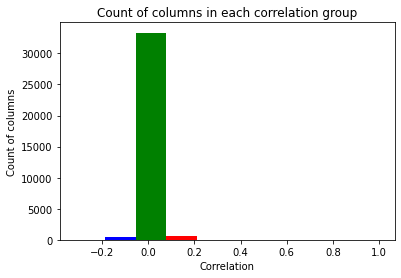

In [6]:
import matplotlib.pyplot as plt

N, bins, patches  = plt.hist(correlation)


patches[1].set_facecolor('blue')
patches[2].set_facecolor('green')
patches[3].set_facecolor('red')
# rest are default colors

plt.xlabel('Correlation')
plt.ylabel('Count of columns')
plt.title('Count of columns in each correlation group')

plt.show()

Since all of the word frequencies(x-variables) have almost no correlation with whether the email being spam or not (y), it can be concluded that the x-variables are not independent among each other. The x-variables are most likely dependant among each other.

##### Scaling

In [7]:
from sklearn.preprocessing import MaxAbsScaler

mas = MaxAbsScaler()
mas.fit(xTrain_cv)
xTrainScaled = mas.transform(xTrain_cv)
xTestScaled = mas.transform(xTest_cv)

### Modelling Data

In [8]:
def modelData(model, scaled=True):
  x = xTrainScaled if scaled else xTrain_cv
  y = yTrain
  model.fit(x,y)
  return model

In [9]:
def display_score(trained_model, scaled = True):
  x = xTestScaled if scaled else xTest_cv
  y = yTest
  y_pred = trained_model.predict(x)
  acc = trained_model.score(x, y)
  prec = precision_score(y, y_pred)
  f1scre = f1_score(y, y_pred)
  recal = recall_score(y, y_pred)

  print(f"Accuracy: {acc}\nPrecision: {prec}\nF1 Score: {f1scre}\nRecall Score: {recal}")

In [10]:
customTests = [
  "Hello sir! When is the deadline for CSE422 project report submission?",
  "Dear Students, The University is happy to offer a student transport service and wishes to keep the price as low as feasible while covering the cost of the service. You all know that the price of fuel has increased significantly: the price of diesel has increased by 42.5% (Previous price- Tk.80, New price Tk.114).Bus fares have already been raised across the country. Despite the increase in the fuel price, the University will keep the student transport fares unchanged for the remainder of the current semester. There will be a need, however, to increase the fare to Tk. 90 from Tk.70 with effect from the start of the fall semester. The University hopes that you will understand the pressures that have led to this change. Best regards, Office of the Registrar",
  "ONLY BOYS CHECK MY BIO 😳🔞",
  "Click here to get free discord nitro"
  ]
customTests_cv = cv.transform(customTests)
customTestsScaled = mas.transform(customTests_cv)

def getCustomTestResults(model, scaled=True):

  results = model.predict(customTestsScaled if scaled else customTests_cv)
  assert len(results) == len(customTests), f"length of results, {len(results)} and tests, {len(customTests)} are unequal"
  for i in range(len(results)):
    spam = "spam" if results[i] == 1 else "ok"
    if len(customTests[i]) > 80:
      print(f"{spam}  -->  \"{customTests[i][0:35]} ... {customTests[i][-35:]}\"")
    else:
      print(f"{spam}  -->  \"{customTests[i]}\"")

##### Multinomial Naive Bayes

In [11]:
from sklearn.naive_bayes import MultinomialNB as MNB

# scaled
mnbModelScaled = modelData(MNB())

display_score(mnbModelScaled)

getCustomTestResults(mnbModelScaled)

Accuracy: 0.9692712906057945
Precision: 0.9917695473251029
F1 Score: 0.9323017408123792
Recall Score: 0.8795620437956204
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
ok  -->  "ONLY BOYS CHECK MY BIO 😳🔞"
ok  -->  "Click here to get free discord nitro"


In [12]:
mnbModel = modelData(MNB(), False)

display_score(mnbModel, False)

getCustomTestResults(mnbModel, False)

Accuracy: 0.9885864793678666
Precision: 0.981549815498155
F1 Score: 0.9761467889908256
Recall Score: 0.9708029197080292
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
ok  -->  "ONLY BOYS CHECK MY BIO 😳🔞"
spam  -->  "Click here to get free discord nitro"


##### Support Vector Classifier

In [13]:
from sklearn.svm import SVC

# scaled
svcModelScaled = modelData( SVC(kernel="linear") )

display_score(svcModelScaled )

getCustomTestResults(svcModelScaled )

Accuracy: 0.971027216856892
Precision: 0.9725490196078431
F1 Score: 0.9376181474480152
Recall Score: 0.9051094890510949
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
ok  -->  "ONLY BOYS CHECK MY BIO 😳🔞"
ok  -->  "Click here to get free discord nitro"


In [14]:
svcModel = modelData( SVC(kernel="linear") , False)

display_score(svcModel, False)

getCustomTestResults(svcModel, False)

Accuracy: 0.9859525899912204
Precision: 0.9708029197080292
F1 Score: 0.9708029197080292
Recall Score: 0.9708029197080292
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
ok  -->  "ONLY BOYS CHECK MY BIO 😳🔞"
spam  -->  "Click here to get free discord nitro"


##### Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier as RFC

# scaled
rfcModelScaled = modelData(RFC(n_estimators=50))

display_score(rfcModelScaled)

getCustomTestResults(rfcModelScaled)

Accuracy: 0.961369622475856
Precision: 0.9914529914529915
F1 Score: 0.9133858267716537
Recall Score: 0.8467153284671532
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
ok  -->  "ONLY BOYS CHECK MY BIO 😳🔞"
spam  -->  "Click here to get free discord nitro"


In [16]:
rfcModel = modelData(RFC(n_estimators=50), False)

display_score(rfcModel, False)

getCustomTestResults(rfcModel, False)

Accuracy: 0.9701492537313433
Precision: 0.9918032786885246
F1 Score: 0.9343629343629344
Recall Score: 0.8832116788321168
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
ok  -->  "ONLY BOYS CHECK MY BIO 😳🔞"
spam  -->  "Click here to get free discord nitro"
